In [31]:
import pandas_market_calendars as mcal
import pandas as pd
import numpy as np

## Remove non trading days

In [32]:
six = mcal.get_calendar('SIX')


In [33]:
df = pd.read_excel('data.xlsx')

str(df['DATE'].min().date())

'2022-01-03'

In [34]:
start = df['DATE'].min().date()
end = df['DATE'].max().date()
schedule = six.schedule(start_date=start, end_date=end)


In [35]:
df[~df['DATE'].isin(schedule.index)]

,DATE,CREDIT SUISSE GROUP - TOT RETURN IND
74,2022-04-15,333.85
75,2022-04-18,333.85
103,2022-05-26,318.95
110,2022-06-06,311.77
150,2022-08-01,261.77
255,2022-12-26,142.07
259,2022-12-30,137.98
260,2023-01-02,137.98


In [36]:
upd_df = df[df['DATE'].isin(schedule.index)]

In [37]:
def print_days_without_price_change(df):
    prev_row = None
    j = 0

    for i, row in df.iterrows():
        if j !=  0:
            if row['CREDIT SUISSE GROUP - TOT RETURN IND'] == prev_row['CREDIT SUISSE GROUP - TOT RETURN IND']:
                print(row['DATE'])

        j = 1
        prev_row = row

In [38]:
print_days_without_price_change(upd_df)

In [39]:
upd_df

,DATE,CREDIT SUISSE GROUP - TOT RETURN IND
0,2022-01-03,422.59
1,2022-01-04,427.71
2,2022-01-05,430.04
3,2022-01-06,431.43
4,2022-01-07,431.80
...,...,...
312,2023-03-15,84.71
313,2023-03-16,100.94
314,2023-03-17,92.85
315,2023-03-20,41.09


In [40]:
TOTAL = 1

In [41]:
def count_cumulitive_likelihood(likelihood):
    cum_lklhd = [likelihood[0]]
    for i in range(1, len(likelihood)):
        cum_lklhd.append(cum_lklhd[i-1] + likelihood[i])
        
    return cum_lklhd


def get_ranked_pnl(likelihood, pnl):
    ranked_pnl = pd.DataFrame({
    'PnL': pnl,
    'Weight' : likelihood
    })
    ranked_pnl = ranked_pnl.sort_values(by=['PnL'])
    ranked_pnl['Cumulative_likelihood'] = count_cumulitive_likelihood(ranked_pnl['Weight'].array)
    return ranked_pnl


def calculate_abs_var(ranked_pnl, c=0.01):
    for _, row in ranked_pnl.iterrows():
        if c < row['Cumulative_likelihood']:
            return -row['PnL']
    
    
def calculate_relative_var(ranked_pnl, c=.01):
    abs_VaR = calculate_abs_var(ranked_pnl)
    return_VaR = -abs_VaR / TOTAL
    return_expected = ranked_pnl['PnL'].mean() / TOTAL
    return TOTAL * (return_expected - return_VaR)

## Use dates before 2023

In [42]:
prices2022= upd_df[upd_df['DATE'] < '2023-01-01'].drop('DATE', axis=1)

In [43]:
prices2022.columns = ['CS']

In [44]:
prices2022

,CS
0,422.59
1,427.71
2,430.04
3,431.43
4,431.80
...,...
253,139.03
254,142.07
256,142.27
257,138.13


In [45]:
daily_returns2022 = prices2022.pct_change(1).tail(-1)
N2022 = len(daily_returns2022)

In [46]:
investment_values2022 = 1 + daily_returns2022
investment_values2022.columns = ['Portfolio']


In [47]:
investment_values2022

,Portfolio
1,1.012116
2,1.005448
3,1.003232
4,1.000858
5,1.012714
...,...
253,0.987639
254,1.021866
256,1.001408
257,0.970900


In [48]:
pnl2022 = investment_values2022['Portfolio'] - TOTAL

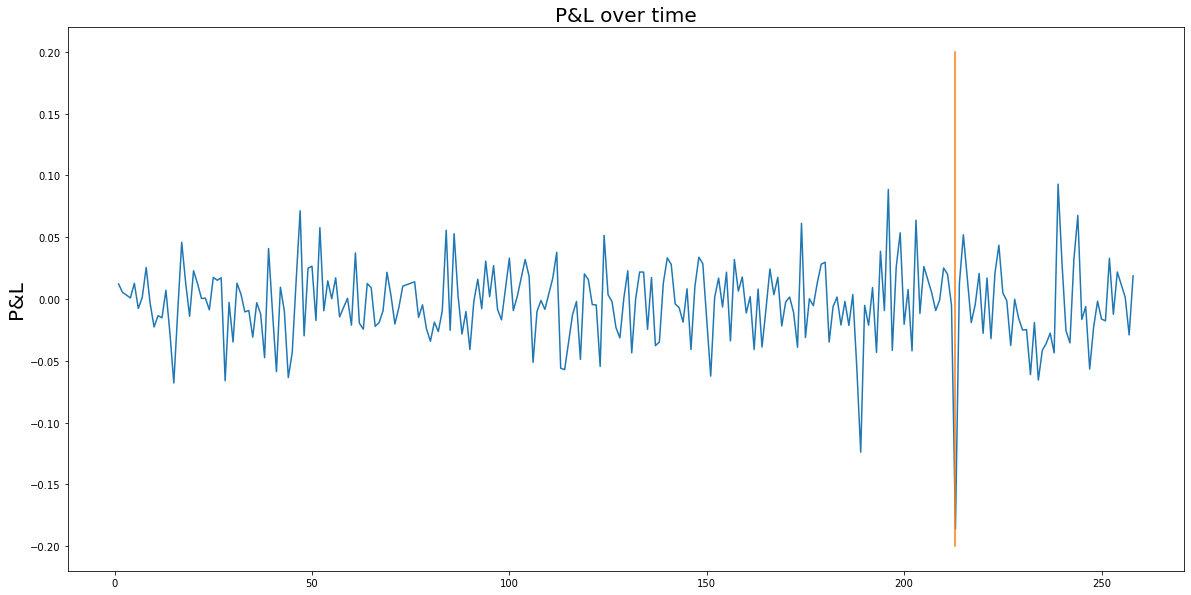

In [49]:
from matplotlib import pyplot as plt


plt.rcParams["figure.figsize"] = (20,10)


plt.plot(pnl2022.index.to_numpy(), pnl2022)
plt.plot([213 for _ in range(0, N2022)], np.linspace(-.2, .2, N2022))
plt.ylabel('P&L', fontsize=20)
plt.title('P&L over time', fontsize=20)
plt.show()

### Normal

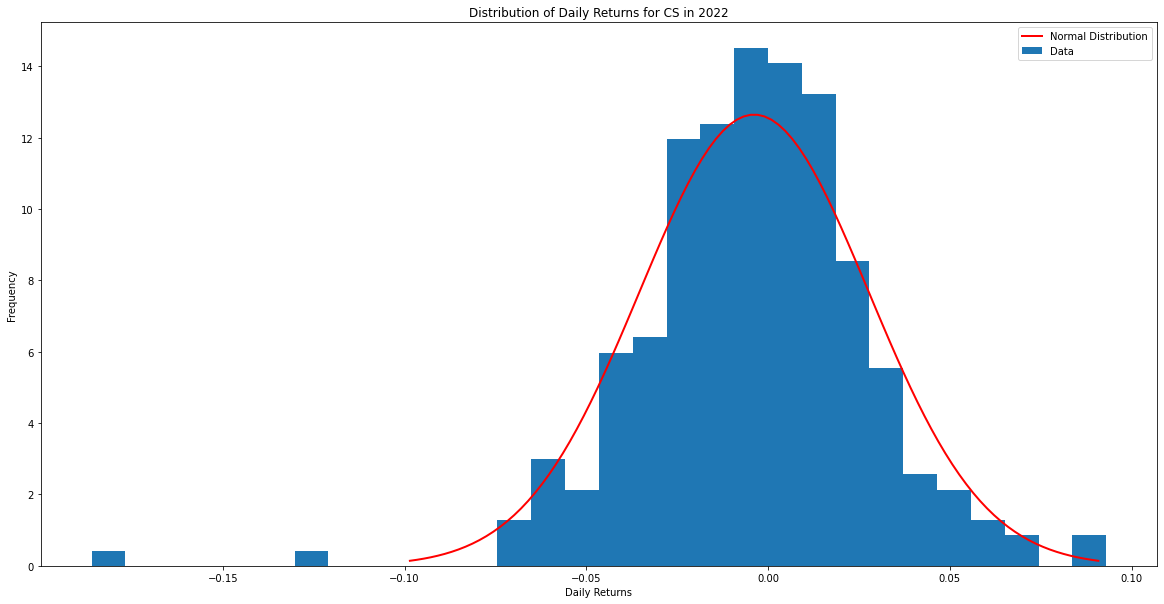

0.05575289217546453

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# generate some sample data
np.random.seed(123)

# calculate mean and standard deviation of the data
mu, sigma = daily_returns2022.mean()[0], daily_returns2022.std()[0]

# generate normal distribution with same mean and standard deviation
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
pdf = norm.pdf(x, mu, sigma)

# plot histogram of data and normal distribution
fig, ax = plt.subplots()
ax.hist(daily_returns2022['CS'], bins=30, density=True)
ax.plot(x, pdf, color='red', linewidth=2)
ax.set_xlabel('Daily Returns')
ax.set_ylabel('Frequency')
ax.legend(['Normal Distribution', 'Data'])
ax.set_title('Distribution of Daily Returns for CS in 2022')

plt.show()


-TOTAL * (sigma * norm.ppf(0.05) + mu)

### Equal weights 2022

In [20]:
likelihood2022 = [1/N2022 for _ in  range(N2022)]
default_pnl2022 = get_ranked_pnl(likelihood2022, pnl2022)
calculate_abs_var(default_pnl2022), calculate_relative_var(default_pnl2022)

(0.06801288104404246, 0.06416611618270836)

In [21]:
default_pnl2022.round(3) ### extrapolation can be used

,PnL,Weight,Cumulative_likelihood
213,-0.186,0.004,0.004
189,-0.124,0.004,0.008
15,-0.068,0.004,0.012
28,-0.066,0.004,0.016
234,-0.066,0.004,0.020
...,...,...,...
203,0.064,0.004,0.984
244,0.068,0.004,0.988
47,0.071,0.004,0.992
196,0.089,0.004,0.996


### Exponential declining weights (2022)

In [22]:
def get_exponential_weight(alpha, i, n):
    return alpha**(n - i) * (1 - alpha) / (1 - alpha**n)

def get_exponential_weights(alpha, n):
    return np.array(
        [get_exponential_weight(alpha, i, n) for i in range(1, n+1)]
    )

alpha = .95
likelihood = get_exponential_weights(alpha, N2022)
exp_ranked_pnl2022 = get_ranked_pnl(likelihood, pnl2022)

exp_ranked_pnl2022.head(10).round(3)

,PnL,Weight,Cumulative_likelihood
213,-0.186,0.005,0.005
189,-0.124,0.002,0.007
15,-0.068,0.000,0.007
28,-0.066,0.000,0.007
234,-0.066,0.015,0.022
44,-0.064,0.000,0.022
151,-0.062,0.000,0.022
232,-0.061,0.014,0.036
41,-0.059,0.000,0.036
114,-0.057,0.000,0.036


### Volatility adjusted returns

In [26]:
def forecast_variance(returns, initial_value, alpha, N):
    variance_forecast = [initial_value]

    for i in range(1, N+1):
        forecast = alpha * variance_forecast[i-1]  +  (1 - alpha) * returns.iloc[i-1] **2 
        variance_forecast.append(forecast)
    
    return np.array(variance_forecast)
    
def forecast_volatility(returns, initial_value, N, alpha=.95):
    return forecast_variance(returns, initial_value, alpha, N) ** .5

In [27]:
alpha = .95

initial_variance = 0.00064


In [29]:
volatility_forecast2022 = forecast_volatility(daily_returns2022['CS'], initial_variance, N2022, alpha)
latest_volatility_forecast2022 = volatility_forecast2022[-1]

In [30]:
adj_coeff_2022 = latest_volatility_forecast2022 / volatility_forecast2022[:N2022]
vol_adj_return2022 = daily_returns2022['CS'].to_numpy() * adj_coeff_2022
volatility_adjusted_portfolio2022 = TOTAL * (1 + vol_adj_return2022)
#vol_adjusted_pnl = vol_adjusted_portfolio - TOTAL

In [36]:
#vol_adj_investment_values2022 = 1 + daily_returns2022
vol_adjusted_pnl2022 = volatility_adjusted_portfolio2022 - TOTAL#pd.DataFrame({'Portfolio': volatility_adjusted_portfolio}) - TOTAL
likelihood = [1/N2022 for _ in  range(N2022)]
ranked_vol_adjusted_pnl2022 = get_ranked_pnl(likelihood, pnl=vol_adjusted_pnl2022)
calculate_abs_var(ranked_vol_adjusted_pnl2022)

0.11650847169333811

In [38]:
ranked_vol_adjusted_pnl2022.round(3)

,PnL,Weight,Cumulative_likelihood
207,-0.198,0.004,0.004
183,-0.168,0.004,0.008
14,-0.117,0.004,0.012
27,-0.106,0.004,0.016
43,-0.084,0.004,0.020
...,...,...,...
233,0.082,0.004,0.984
46,0.084,0.004,0.988
81,0.086,0.004,0.992
168,0.089,0.004,0.996


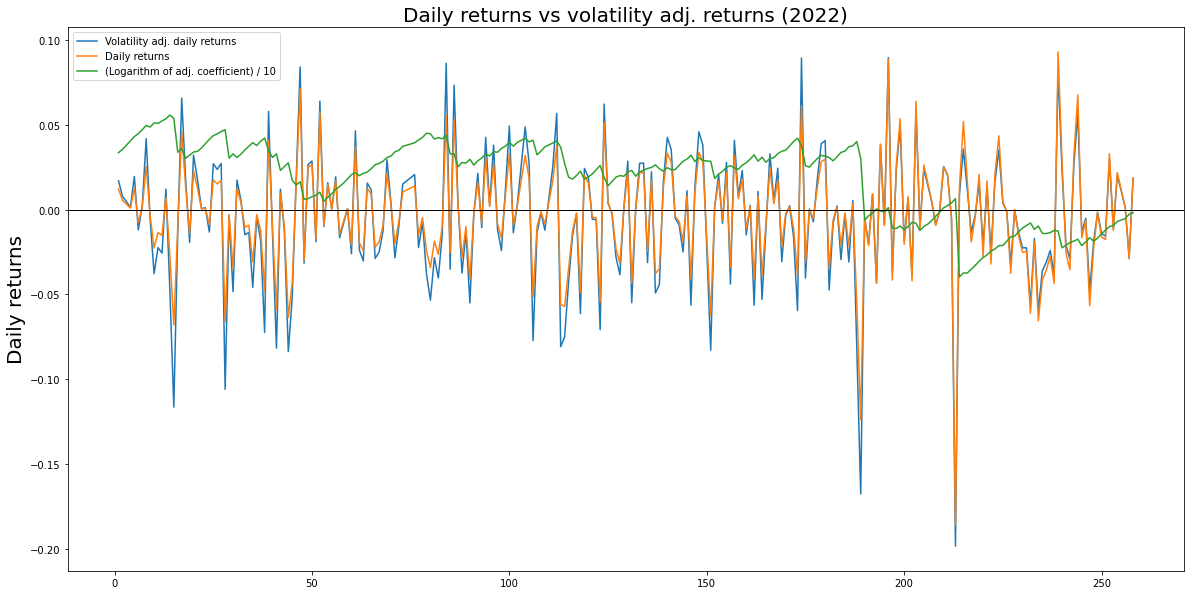

In [40]:
from matplotlib import pyplot as plt


plt.rcParams["figure.figsize"] = (20,10)


plt.plot(pnl2022.index.to_numpy(), vol_adj_return2022, label='Volatility adj. daily returns')
plt.plot(pnl2022.index.to_numpy(), daily_returns2022['CS'], label='Daily returns')
plt.plot(pnl2022.index.to_numpy(), np.log(adj_coeff_2022) / 10, label='(Logarithm of adj. coefficient) / 10')

plt.axhline(0, color='black', linewidth=1)

#plt.plot([213 for _ in range(0, N2022)], np.linspace(-.2, .2, N2022))
plt.ylabel('Daily returns', fontsize=20)
plt.title('Daily returns vs volatility adj. returns (2022)', fontsize=20)
plt.legend()
plt.show()